In [18]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

import warnings
warnings.filterwarnings('ignore')

In [2]:
NorESM = xr.open_dataset('outputs_ssp245.nc').rename({'lat': 'latitude', 'lon': 'longitude'}).compute()
NorESM['pr'] *= 86400
NorESM['pr90'] *= 86400

In [3]:
from glob import glob
def preprocess(ds):
    """
    Promote the ensemble member attribute to a coord
    """
    return ds.assign_coords(member=("member", [ds.attrs['source'].split('_')[2]]))

# Subtract baseline values
UKESM_baseline = xr.open_dataset(f"UKESM1-0-LL_piControl_r1i1p1f2.nc").mean('year')

UKESM_files = list(glob(f"UKESM1-0-LL_ssp245_*"))
ens_ds = []
for f in UKESM_files:
    ds = xr.open_dataset(f)
    ds['member'] = [int(f.split('_')[2][1])]
    ds.assign_coords(member="member")
    ens_ds.append(ds)
UKESM_orig = xr.concat(ens_ds, dim='member') - UKESM_baseline

# Fix some metadata to help iris
UKESM_orig.lat.attrs['units'] = 'degrees'
UKESM_orig = UKESM_orig.rename({'year': 'time', 'lat': 'latitude', 'lon': 'longitude'})

UKESM_orig['pr'] *= 86400
UKESM_orig['pr90'] *= 86400

In [4]:
# Regrid
regridder = xe.Regridder(UKESM_orig, NorESM, 'conservative', periodic=True)
UKESM = regridder(UKESM_orig)

# Evaluate predictions

Text(0.5, 1.0, 'NorESM pr90')

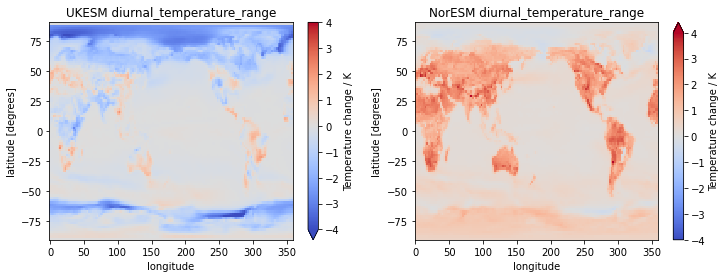

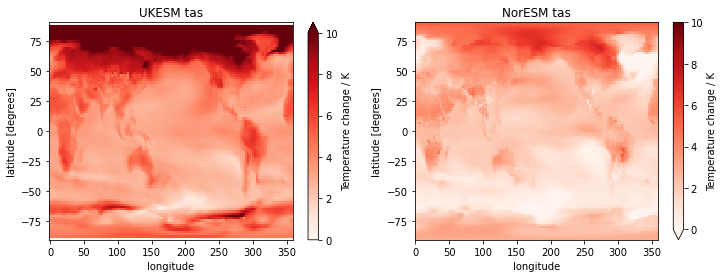

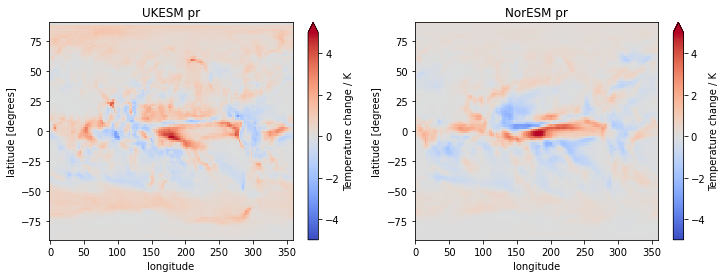

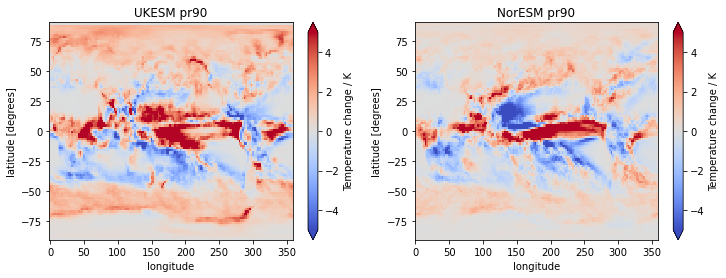

In [5]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)

time = 2100 # 2050

fig = plt.figure(figsize=(12, 4))
plt.subplot(121)
UKESM["diurnal_temperature_range"].sel(time=time).mean('member').plot(cmap="coolwarm", vmin=-4, vmax=4, 
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().set_title(f"UKESM diurnal_temperature_range")

plt.subplot(122)
NorESM["diurnal_temperature_range"].sel(time=time).mean('member').plot(cmap="coolwarm", vmin=-4, vmax=4, 
                          cbar_kwargs={"label":"Temperature change / K"})
plt.gca().set_title(f"NorESM diurnal_temperature_range")

fig = plt.figure(figsize=(12, 4))
plt.subplot(121)
UKESM["tas"].sel(time=time).mean('member').plot(cmap="Reds", vmin=0, vmax=10,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().set_title(f"UKESM tas")

plt.subplot(122)
NorESM["tas"].sel(time=time).mean('member').plot(cmap="Reds", vmin=0, vmax=10,
                          cbar_kwargs={"label":"Temperature change / K"})
plt.gca().set_title(f"NorESM tas")


fig = plt.figure(figsize=(12, 4))
plt.subplot(121)
(UKESM["pr"]).sel(time=time).mean('member').plot(cmap="coolwarm", vmin=-5, vmax=5, 
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().set_title(f"UKESM pr")

plt.subplot(122)
(NorESM["pr"]).sel(time=time).mean('member').plot(cmap="coolwarm", vmin=-5, vmax=5, 
                          cbar_kwargs={"label":"Temperature change / K"})
plt.gca().set_title(f"NorESM pr")


fig = plt.figure(figsize=(12, 4))
plt.subplot(121)
(UKESM["pr90"]).sel(time=time).mean('member').plot(cmap="coolwarm", vmin=-5, vmax=5, 
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().set_title(f"UKESM pr90")

plt.subplot(122)
(NorESM["pr90"]).sel(time=time).mean('member').plot(cmap="coolwarm", vmin=-5, vmax=5, 
                          cbar_kwargs={"label":"Temperature change / K"})
plt.gca().set_title(f"NorESM pr90")


### These are the metrics to be scored on

In [20]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data

print(f"RMSE at 2015: {get_rmse(NorESM['tas'].sel(time=2015).mean('member'), UKESM['tas'].sel(time=2015).mean('member'))}")
print(f"RMSE at 2050: {get_rmse(NorESM['tas'].sel(time=2050).mean('member'), UKESM['tas'].sel(time=2050).mean('member'))}")
print(f"RMSE at 2100: {get_rmse(NorESM['tas'].sel(time=2100).mean('member'), UKESM['tas'].sel(time=2100).mean('member'))}")

RMSE at 2015: 0.7893183604027597
RMSE at 2050: 1.7084273429026864
RMSE at 2100: 2.702734474335186


In [21]:
print(f"RMSE at 2015: {get_rmse(NorESM['diurnal_temperature_range'].sel(time=2015).mean('member'), UKESM['diurnal_temperature_range'].sel(time=2015).mean('member'))}")
print(f"RMSE at 2050: {get_rmse(NorESM['diurnal_temperature_range'].sel(time=2050).mean('member'), UKESM['diurnal_temperature_range'].sel(time=2050).mean('member'))}")
print(f"RMSE at 2100: {get_rmse(NorESM['diurnal_temperature_range'].sel(time=2100).mean('member'), UKESM['diurnal_temperature_range'].sel(time=2100).mean('member'))}")

RMSE at 2015: 1.048917038063076
RMSE at 2050: 1.1739844890028686
RMSE at 2100: 1.3350124671260466


In [22]:
print(f"RMSE at 2015: {get_rmse(NorESM['pr'].sel(time=2015).mean('member'), UKESM['pr'].sel(time=2015).mean('member'))}")
print(f"RMSE at 2050: {get_rmse(NorESM['pr'].sel(time=2050).mean('member'), UKESM['pr'].sel(time=2050).mean('member'))}")
print(f"RMSE at 2100: {get_rmse(NorESM['pr'].sel(time=2100).mean('member'), UKESM['pr'].sel(time=2100).mean('member'))}")

RMSE at 2015: 0.5765573311202621
RMSE at 2050: 0.5886688315365347
RMSE at 2100: 0.8155571069045522


In [23]:
print(f"RMSE at 2015: {get_rmse(NorESM['pr90'].sel(time=2015).mean('member'), UKESM['pr90'].sel(time=2015).mean('member'))}")
print(f"RMSE at 2050: {get_rmse(NorESM['pr90'].sel(time=2050).mean('member'), UKESM['pr90'].sel(time=2050).mean('member'))}")
print(f"RMSE at 2100: {get_rmse(NorESM['pr90'].sel(time=2100).mean('member'), UKESM['pr90'].sel(time=2100).mean('member'))}")

RMSE at 2015: 1.7339654405625902
RMSE at 2050: 1.7707159073471619
RMSE at 2100: 2.4793491511844428


### Variability

In [32]:
print(f"RMSE at 2015: {get_rmse(NorESM['tas'].sel(time=2015).sel(member=1), NorESM['tas'].sel(time=2015)).mean()}")
print(f"RMSE at 2050: {get_rmse(NorESM['tas'].sel(time=2050).sel(member=1), NorESM['tas'].sel(time=2050)).mean()}")
print(f"RMSE at 2100: {get_rmse(NorESM['tas'].sel(time=2100).sel(member=1), NorESM['tas'].sel(time=2100)).mean()}")

RMSE at 2015: 0.5694612995792809
RMSE at 2050: 0.5314993574817706
RMSE at 2100: 0.5909861734787866


In [33]:
print(f"RMSE at 2015: {get_rmse(NorESM['diurnal_temperature_range'].sel(time=2015).sel(member=1), NorESM['diurnal_temperature_range'].sel(time=2015)).mean()}")
print(f"RMSE at 2050: {get_rmse(NorESM['diurnal_temperature_range'].sel(time=2050).sel(member=1), NorESM['diurnal_temperature_range'].sel(time=2050)).mean()}")
print(f"RMSE at 2100: {get_rmse(NorESM['diurnal_temperature_range'].sel(time=2100).sel(member=1), NorESM['diurnal_temperature_range'].sel(time=2100)).mean()}")

RMSE at 2015: 0.197599455195918
RMSE at 2050: 0.21461531858587657
RMSE at 2100: 0.22453469952133512


In [34]:
print(f"RMSE at 2015: {get_rmse(NorESM['pr'].sel(time=2015).sel(member=1), NorESM['pr'].sel(time=2015)).mean()}")
print(f"RMSE at 2050: {get_rmse(NorESM['pr'].sel(time=2050).sel(member=1), NorESM['pr'].sel(time=2050)).mean()}")
print(f"RMSE at 2100: {get_rmse(NorESM['pr'].sel(time=2100).sel(member=1), NorESM['pr'].sel(time=2100)).mean()}")

RMSE at 2015: 0.745603613066641
RMSE at 2050: 0.7428844622471299
RMSE at 2100: 0.8632983138281757


In [35]:
print(f"RMSE at 2015: {get_rmse(NorESM['pr90'].sel(time=2015).sel(member=1), NorESM['pr90'].sel(time=2015)).mean()}")
print(f"RMSE at 2050: {get_rmse(NorESM['pr90'].sel(time=2050).sel(member=1), NorESM['pr90'].sel(time=2050)).mean()}")
print(f"RMSE at 2100: {get_rmse(NorESM['pr90'].sel(time=2100).sel(member=1), NorESM['pr90'].sel(time=2100)).mean()}")

RMSE at 2015: 2.209138848264588
RMSE at 2050: 2.2619325326627586
RMSE at 2100: 2.5548056739768668


In [31]:
def get_sd(x):
    weights = np.cos(np.deg2rad(x.latitude))
    return x.weighted(weights).mean(['latitude', 'longitude'])

print(f"SD at 2050: {get_sd(NorESM['tas'].sel(time=2050))}")
print(f"SD at 2100: {get_sd(NorESM['tas'].sel(time=2100))}")



SD at 2050: <xarray.DataArray 'tas' (member: 3)>
array([1.3973569 , 1.38074728, 1.39715888])
Coordinates:
    time      int64 2050
    quantile  float64 0.9
  * member    (member) int64 1 2 3
SD at 2100: <xarray.DataArray 'tas' (member: 3)>
array([2.18288285, 2.00798298, 2.27323857])
Coordinates:
    time      int64 2100
    quantile  float64 0.9
  * member    (member) int64 1 2 3


## Time averaged RMSE

In [10]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude', 'time'])).data

print(f"RMSE acros ssp245: {get_rmse(NorESM['tas'].mean('member'), UKESM['tas'].mean('member'))}")

RMSE at 2015: 1.8576828611764795


In [11]:
print(f"RMSE acros ssp245: {get_rmse(NorESM['diurnal_temperature_range'].mean('member'), UKESM['diurnal_temperature_range'].mean('member'))}")

RMSE at 2015: 1.2223335320248414


In [12]:
print(f"RMSE acros ssp245: {get_rmse(NorESM['pr'].mean('member'), UKESM['pr'].mean('member'))}")

RMSE at 2015: 0.8358543457948764


In [13]:
print(f"RMSE acros ssp245: {get_rmse(NorESM['pr90'].mean('member'), UKESM['pr90'].mean('member'))}")

RMSE at 2015: 2.415967596046167


## NorESM variability

In [14]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude', 'time'])).data

print(f"RMSE across members: {get_rmse(NorESM['tas'].sel(member=1), NorESM['tas'])}")

RMSE at 2015: [0.         0.83401982 0.85165232]


In [15]:
print(f"RMSE across members: {get_rmse(NorESM['diurnal_temperature_range'].sel(member=1), NorESM['diurnal_temperature_range'])}")

RMSE at 2015: [0.         0.31270084 0.31569514]


In [16]:
print(f"RMSE across members: {get_rmse(NorESM['pr'].sel(member=1), NorESM['pr'])}")

RMSE at 2015: [0.         1.24340099 1.22164146]


In [17]:
print(f"RMSE across members: {get_rmse(NorESM['pr90'].sel(member=1), NorESM['pr90'])}")

RMSE at 2015: [0.         3.61174891 3.58967365]
